In [4]:
'''Visualization of the filters of VGG16, via gradient ascent in input space.

This script can run on CPU in a few minutes.

Results example: http://i.imgur.com/4nj4KjN.jpg
'''
from __future__ import print_function

import numpy as np
import time
from PIL import Image
from keras.preprocessing.image import *
from keras.applications import ResNet50
from keras import backend as K

# For some reason cant import this:
def save_img(path,
             x,
             data_format=None,
             file_format=None,
             scale=True, **kwargs):
    """Saves an image stored as a Numpy array to a path or file object.
    # Arguments
        path: Path or file object.
        x: Numpy array.
        data_format: Image data format,
            either "channels_first" or "channels_last".
        file_format: Optional file format override. If omitted, the
            format to use is determined from the filename extension.
            If a file object was used instead of a filename, this
            parameter should always be used.
        scale: Whether to rescale image values to be within `[0, 255]`.
        **kwargs: Additional keyword arguments passed to `PIL.Image.save()`.
    """
    img = array_to_img(x, data_format=data_format, scale=scale)
    img.save(path, format=file_format, **kwargs)

# def array_to_img(x, data_format=None, scale=True):
#     """Converts a 3D Numpy array to a PIL Image instance.
#     # Arguments
#         x: Input Numpy array.
#         data_format: Image data format.
#             either "channels_first" or "channels_last".
#         scale: Whether to rescale image values
#             to be within `[0, 255]`.
#     # Returns
#         A PIL Image instance.
#     # Raises
#         ImportError: if PIL is not available.
#         ValueError: if invalid `x` or `data_format` is passed.
#     """
#     if pil_image is None:
#         raise ImportError('Could not import PIL.Image. '
#                           'The use of `array_to_img` requires PIL.')
#     x = np.asarray(x, dtype=K.floatx())
#     if x.ndim != 3:
#         raise ValueError('Expected image array to have rank 3 (single image). '
#                          'Got array with shape:', x.shape)

#     if data_format is None:
#         data_format = K.image_data_format()
#     if data_format not in {'channels_first', 'channels_last'}:
#         raise ValueError('Invalid data_format:', data_format)

#     # Original Numpy array x has format (height, width, channel)
#     # or (channel, height, width)
#     # but target PIL image has format (width, height, channel)
#     if data_format == 'channels_first':
#         x = x.transpose(1, 2, 0)
#     if scale:
#         x = x + max(-np.min(x), 0)
#         x_max = np.max(x)
#         if x_max != 0:
#             x /= x_max
#         x *= 255
#     if x.shape[2] == 3:
#         # RGB
#         return pil_image.fromarray(x.astype('uint8'), 'RGB')
#     elif x.shape[2] == 1:
#         # grayscale
#         return pil_image.fromarray(x[:, :, 0].astype('uint8'), 'L')
#     else:
#         raise ValueError('Unsupported channel number: ', x.shape[2])


In [5]:
model1 = ResNet50(include_top=False, weights = 'imagenet')
model2 = ResNet50(include_top=False, weights = 'imagenet')
model2.load_weights(by_name=True, filepath="models/fully_con_reduced_transform_visuals_datalen-40720_epochs-2_init_lr-0.01_momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300.hdf5")

In [6]:
for index, layer in enumerate(model1.layers):
    try:
        print(index, layer.name, layer.get_config()['filters'])
    except:
        continue


2 conv1 64
6 res2a_branch2a 64
9 res2a_branch2b 64
12 res2a_branch2c 256
13 res2a_branch1 256
18 res2b_branch2a 64
21 res2b_branch2b 64
24 res2b_branch2c 256
28 res2c_branch2a 64
31 res2c_branch2b 64
34 res2c_branch2c 256
38 res3a_branch2a 128
41 res3a_branch2b 128
44 res3a_branch2c 512
45 res3a_branch1 512
50 res3b_branch2a 128
53 res3b_branch2b 128
56 res3b_branch2c 512
60 res3c_branch2a 128
63 res3c_branch2b 128
66 res3c_branch2c 512
70 res3d_branch2a 128
73 res3d_branch2b 128
76 res3d_branch2c 512
80 res4a_branch2a 256
83 res4a_branch2b 256
86 res4a_branch2c 1024
87 res4a_branch1 1024
92 res4b_branch2a 256
95 res4b_branch2b 256
98 res4b_branch2c 1024
102 res4c_branch2a 256
105 res4c_branch2b 256
108 res4c_branch2c 1024
112 res4d_branch2a 256
115 res4d_branch2b 256
118 res4d_branch2c 1024
122 res4e_branch2a 256
125 res4e_branch2b 256
128 res4e_branch2c 1024
132 res4f_branch2a 256
135 res4f_branch2b 256
138 res4f_branch2c 1024
142 res5a_branch2a 512
145 res5a_branch2b 512
148 res5a_b

In [14]:
# The name of the layer whose filters to visualize:
# layer_name = 'res3c_branch2b'
layer_name = 'res2a_branch2a'

In [15]:
# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
# layer_name = 'conv1'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# build the VGG16 network with ImageNet weights
# model = vgg16.VGG16(weights='imagenet', include_top=False)
# print('Model loaded.')

model1.summary()
# model2.summa
# this is the placeholder for the input images
input_img1 = model1.input
input_img2 = model2.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict1 = dict([(layer.name, layer) for layer in model1.layers[1:]])
layer_dict2 = dict([(layer.name, layer) for layer in model2.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters1 = []
kept_filters2 = []
num_filters = min(200, layer_dict1[layer_name].get_config()['filters'])

print("_" * 80)
print("Maximizing activation for %s filters" % num_filters)
for filter_index in range(num_filters):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print("\r" + " " * 80, end=" ")
    print('\rProcessing filter %d' % filter_index, end=" ")
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output1 = layer_dict1[layer_name].output
    layer_output2 = layer_dict2[layer_name].output

    if K.image_data_format() == 'channels_first':
        loss1 = K.mean(layer_output1[:, filter_index, :, :])
        loss2 = K.mean(layer_output2[:, filter_index, :, :])
    else:
        loss1 = K.mean(layer_output1[:, :, :, filter_index])
        loss2 = K.mean(layer_output2[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads1 = K.gradients(loss1, input_img1)[0]
    grads2 = K.gradients(loss2, input_img2)[0]

    # normalization trick: we normalize the gradient
    grads1 = normalize(grads1)
    grads2 = normalize(grads2)

    # this function returns the loss and grads given the input picture
    iterate1 = K.function([input_img1], [loss1, grads1])
    iterate2 = K.function([input_img2], [loss2, grads2])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value1, grads_value1 = iterate1([input_img_data])
        loss_value2, grads_value2 = iterate2([input_img_data])
        input_img_data1 = input_img_data + grads_value1 * step
        input_img_data2 = input_img_data + grads_value2 * step
        print("\r" + " " * 80, end=" ")
        print('\rCurrent loss value:', loss_value1, ' and ', loss_value2, end=" ")
        if loss_value1 <= 0. and loss_value2 <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value1 > 0:
        img = deprocess_image(input_img_data1[0])
        kept_filters1.append((img, loss_value1))
    if loss_value2 > 0:
        img = deprocess_image(input_img_data2[0])
        kept_filters2.append((img, loss_value2))

    end_time = time.time()
    print('\nFilter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 16 filters on a 4 x 4 grid.
n = 4

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters1.sort(key=lambda x: x[1], reverse=True)
kept_filters2.sort(key=lambda x: x[1], reverse=True)
kept_filters1 = kept_filters1[:n * n]
kept_filters2 = kept_filters2[:n * n]
print("\n" + "_" * 80)
print("%s kept filters" % len(kept_filters1))
print("_" * 80)

def make_img(kept_filters, n=4):
    n = min(n, np.floor_divide(len(kept_filters), 2)) # at most 4 x 4 otherwise, min of n and floor(n/2)

    # build a black picture with enough space for
    # our 4 x 4 filters of size 128 x 128, with a 5px margin in between
    margin = 5
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))

    # fill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            img, loss = kept_filters[i * n + j]
            stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                             (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img
    return stitched_filters

stitched_filters1 = make_img(kept_filters1)
stitched_filters2 = make_img(kept_filters2)
# save the result to disk
save_img('plots/ResNet_stitched_layer-%s_filters_%dx%d.png' % (layer_name, n, n), stitched_filters1)
save_img('plots/Violence_stitched_layer-%s_filters_%dx%d.png' % (layer_name, n, n), stitched_filters2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

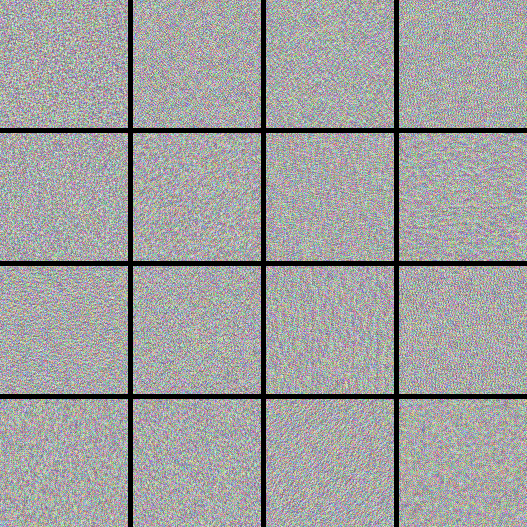

In [16]:
Image.open(open('plots/ResNet_stitched_layer-%s_filters_%dx%d.png' % (layer_name, n, n), 'rb'))

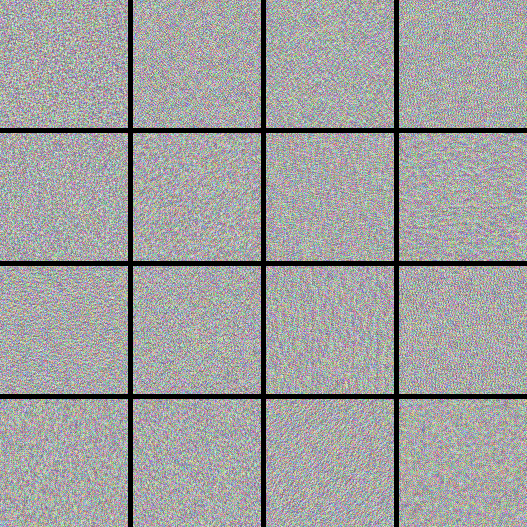

In [17]:
Image.open(open('plots/Violence_stitched_layer-%s_filters_%dx%d.png' % (layer_name, n, n), 'rb'))